In [1]:
from itertools import cycle

In [2]:
class Model:
    def __init__(self, filename):
        self.map = dict()
        self.trains = list()
        self.clock = 0
        self.load(filename)

    def load(self, filename):
        with open(filename, "r") as infile:
            for r, line in enumerate(infile.read().split('\n')):
                for c, char in enumerate(line):
                    if char == ' ':
                        continue

                    elif char == '-':
                        self.map[r, c] = Road(r, c, "WE")

                    elif char == '/':
                        self.map[r, c] = Road(r, c, 'NW')

                    elif char == '\\':
                        self.map[r, c] = Road(r, c, 'NE')

                    elif char == '|':
                        self.map[r, c] = Road(r, c, 'NS')

                    elif char == '+':
                        self.map[r, c] = Intersection(r, c)

                    elif char in ['<', '>']:
                        self.trains.append(Train((r, c), 'E' if char == '>' else 'W', self.map))
                        if self.map.get((r - 1, c), None) and self.map[(r - 1, c)].direction == 'NS':
                            self.map[(r, c)] = Intersection(r, c)
                        else:
                            self.map[(r, c)] = Road(r, c, 'WE')

                    elif char in ['v', '^']:
                        self.trains.append(Train((r, c), 'S' if char == 'v' else 'N', self.map))
                        if self.map.get((r, c - 1)) and self.map[(r, c - 1)].direction == 'WE':
                            self.map[(r, c)] = Intersection(r, c)
                        else:
                            self.map[(r, c)] = Road(r, c, 'NS')

                    else:
                        raise ValueError("'{}' is not recognized".format(char))

    @property
    def size(self):
        return max([x for x, y in self.map.keys()]) + 1, max([y for x, y in self.map.keys()]) + 1, len(self.trains)

    def run(self):
        self.clock += 1
        for train in sorted(self.trains, key=lambda x: (x.r, x.c)):
            train.move()
            if len(self.collisions) != 0:
                self.trains = [train for train in self.trains if train not in self.collisions]
        return

    def persist(self):
        with open("{}.txt".format(self.clock), 'w') as outfile:
            for r in range(self.size[0]):
                chars = ''
                for c in range(self.size[1]):
                    if (r, c) in self.map:
                        if any([train.position == (r, c) for train in self.trains]):
                            chars += str([train for train in self.trains if train.position == (r, c)][0])
                        else:
                            chars += str(self.map[r, c])
                    else:
                        chars += ' '
                outfile.write("{:03d}".format(r) + chars + '\n')
        return

    @property
    def collisions(self):
        cols = set()
        for train in self.trains:
            for other in self.trains:
                if train.position == other.position and train != other:
                    cols.add(train)
        return cols


class Road:
    def __init__(self, r, c, direction):
        if direction not in ['NS', 'WE', 'NE', 'NW']:
            raise ValueError("'{}' is not a valid road axis (direction)".format(direction))
        self.r = r
        self.c = c
        self.direction = direction

    def __str__(self):
        if self.direction == 'NS':
            return '|'
        if self.direction == 'WE':
            return '-'
        if self.direction == 'NE':
            return '\\'
        if self.direction == 'NW':
            return '/'


class Intersection(Road):
    def __init__(self, r, c):
        self.r = r
        self.c = c

    def __str__(self):
        return '+'


class Train:
    def __init__(self, position, direction, railmap):
        if direction not in ['N', 'S', 'W', 'E']:
            raise ValueError("'{}' is not a valid direction".format(direction))
        self.position   = position
        self.direction  = direction
        self.turns      = cycle(['left', 'straight', 'right'])
        self.history    = [{"position": position, "direction": direction}]
        self.name       = "#{}-{}".format(position[0], position[1])
        self.map        = railmap

    def __repr__(self):
        return '<Train {} row={} col={} direction={}>'.format(self.name, self.r, self.c, self.direction)

    @property
    def r(self):
        return self.position[0]

    @property
    def c(self):
        return self.position[1]

    def move(self):
        if self.direction == 'N':
            self.position = (self.r - 1, self.c)

            if isinstance(self.map[self.position], Intersection):
                turn = next(self.turns)
                if turn == 'left':
                    self.direction = 'W'
                elif turn == 'right':
                    self.direction = 'E'
            elif self.map[self.position].direction == 'NW':
                self.direction = 'E'
            elif self.map[self.position].direction == 'NE':
                self.direction = 'W'

        elif self.direction == 'S':
            self.position = (self.r + 1, self.c)

            if isinstance(self.map[self.position], Intersection):
                turn = next(self.turns)
                if turn == 'left':
                    self.direction = 'E'
                elif turn == 'right':
                    self.direction = 'W'
            elif self.map[self.position].direction == 'NW':
                self.direction = 'W'
            elif self.map[self.position].direction == 'NE':
                self.direction = 'E'

        elif self.direction == 'E':
            self.position = (self.r, self.c + 1)

            if isinstance(self.map[self.position], Intersection):
                turn = next(self.turns)
                if turn == 'left':
                    self.direction = 'N'
                elif turn == 'right':
                    self.direction = 'S'
            elif self.map[self.position].direction == 'NW':
                self.direction = 'N'
            elif self.map[self.position].direction == 'NE':
                self.direction = 'S'

        elif self.direction == 'W':
            self.position = (self.r, self.c - 1)

            if isinstance(self.map[self.position], Intersection):
                turn = next(self.turns)
                if turn == 'left':
                    self.direction = 'S'
                elif turn == 'right':
                    self.direction = 'N'
            elif self.map[self.position].direction == 'NW':
                self.direction = 'S'
            elif self.map[self.position].direction == 'NE':
                self.direction = 'N'

        self.history.append({"direction":self.direction, "position":self.position})
        return self

    def __str__(self):
        if self.direction == 'N':
            return '^'
        if self.direction == 'S':
            return 'v'
        if self.direction == 'E':
            return '>'
        if self.direction == 'W':
            return '<'


In [3]:
model = Model('input.txt')

while len(model.trains) != 1:
    model.run()
    
model.trains

[<Train #126-121 row=48 col=62 direction=N>]

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

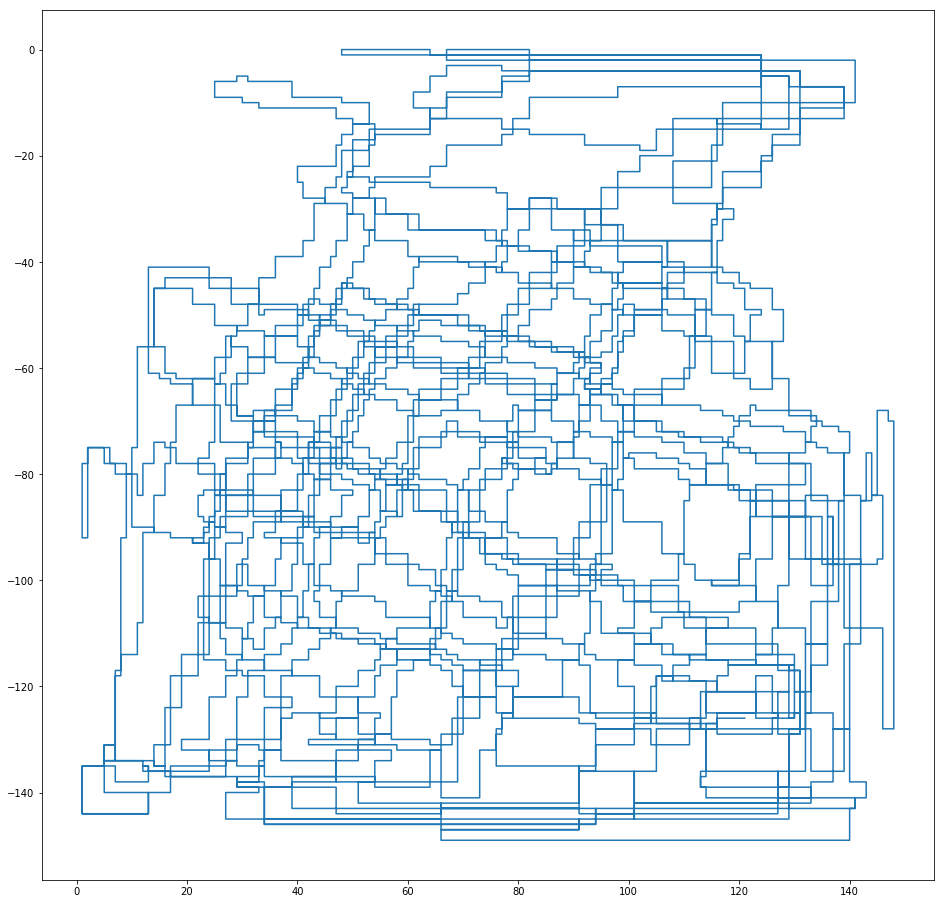

In [5]:
history = model.trains[0].history

plt.figure(figsize=(16,16))
plt.plot([x["position"][1] for x in history], [-x["position"][0] for x in history])
plt.show()